2025-12-18 00:23:19.003280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766017399.025370     289 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766017399.032167     289 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766017399.049902     289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766017399.049932     289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766017399.049935     289 computation_placer.cc:177] computation placer alr

[INFO] Sizes: train= 448000 val= 112000 test= 38000


I0000 00:00:1766017511.192578     289 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/3


I0000 00:00:1766017514.238015     352 service.cc:152] XLA service 0x7b19cc003ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766017514.238066     352 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766017514.686105     352 cuda_dnn.cc:529] Loaded cuDNN version 91002


   5/3500 ━━━━━━━━━━━━━━━━━━━━ 1:44 30ms/step - accuracy: 0.4588 - auc: 0.4356 - loss: 0.6936

I0000 00:00:1766017516.911207     352 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3500/3500 ━━━━━━━━━━━━━━━━━━━━ 110s 30ms/step - accuracy: 0.8922 - auc: 0.9538 - loss: 0.2588 - val_accuracy: 0.9431 - val_auc: 0.9862 - val_loss: 0.1486
Epoch 2/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 103s 30ms/step - accuracy: 0.9459 - auc: 0.9858 - loss: 0.1467 - val_accuracy: 0.9464 - val_auc: 0.9873 - val_loss: 0.1427
Epoch 3/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 103s 29ms/step - accuracy: 0.9580 - auc: 0.9911 - loss: 0.1150 - val_accuracy: 0.9472 - val_auc: 0.9862 - val_loss: 0.1535


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Epoch 1/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 110s 30ms/step - accuracy: 0.8871 - auc: 0.9497 - loss: 0.2710 - val_accuracy: 0.9387 - val_auc: 0.9844 - val_loss: 0.1612
Epoch 2/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 103s 30ms/step - accuracy: 0.9420 - auc: 0.9846 - loss: 0.1546 - val_accuracy: 0.9387 - val_auc: 0.9854 - val_loss: 0.1550
Epoch 3/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 103s 30ms/step - accuracy: 0.9546 - auc: 0.9898 - loss: 0.1237 - val_accuracy: 0.9399 - val_auc: 0.9856 - val_loss: 0.1622

=== TOKENIZATION COMPARISON (p.7) ===
       Tokenizer                                  Tokenizer info  Vocab size  Max len  Accuracy  Precision   Recall       F1
      word_keras   keras.Tokenizer(num_words=..., oov_token=...)       20000      200  0.948789   0.946861 0.950947 0.948900
sentencepiece_hf AutoTokenizer.from_pretrained('albert-base-v2')       30001      200  0.941289   0.927890 0.956947 0.942195
[INFO] Saved: /kaggle/working/tokenization_comparison.csv


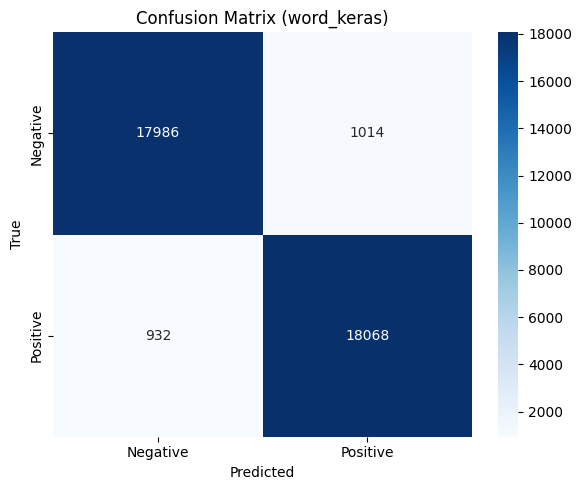

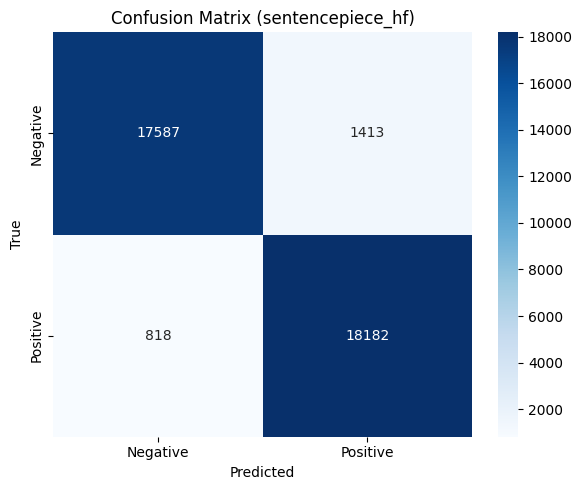


=== INFERENCE TEST: TRAIN SUBSET ===
[INFO] Saved: /kaggle/working/sentiment_train_subset_predictions.csv
Subset accuracy: 0.95
Subset confusion matrix:
 [[ 6  0]
 [ 1 13]]

=== INFERENCE TEST: EXTERNAL TEXTS ===
[INFO] Saved: /kaggle/working/sentiment_external_predictions.csv
[INFO] External texts count: 5


In [1]:
!pip -q install transformers sentencepiece
import os, re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)

from transformers import AutoTokenizer

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.get_logger().setLevel("ERROR")
SEED = 42
tf.keras.utils.set_random_seed(SEED)

train_path = "/kaggle/input/yelp-review-polarity/yelp_review_polarity_csv/train.csv"
test_path  = "/kaggle/input/yelp-review-polarity/yelp_review_polarity_csv/test.csv"

EXTERNAL_TEXTS_PATH = "/kaggle/input/lstm-external-text/external-text.txt"


VAL_FRAC = 0.2
MAX_LEN = 200

WORD_VOCAB = 20000
SP_MODEL_NAME = "albert-base-v2"

EMB_DIM = 128
EPOCHS = 3
BATCH = 128

LIMIT_TRAIN = None
LIMIT_TEST  = None


N_TRAIN_INFER_TEST = 20

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"<br\s*/?>", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def build_lstm_model(vocab_size: int):
    model = Sequential([
        Embedding(vocab_size, EMB_DIM, mask_zero=True),
        LSTM(128, dropout=0.2, recurrent_dropout=0.0, use_cudnn=False),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model


def compute_metrics(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype("int32")
    return {
        "accuracy":  float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred)),
        "recall":    float(recall_score(y_true, y_pred)),
        "f1":        float(f1_score(y_true, y_pred)),
        "cm":        confusion_matrix(y_true, y_pred),
        "y_pred":    y_pred,
    }


# -----------------------------
# Load dataset (CSV)
# -----------------------------
train_df = pd.read_csv(train_path, header=None, names=["label", "text"])
test_df  = pd.read_csv(test_path,  header=None, names=["label", "text"])

train_df["label"] = train_df["label"] - 1
test_df["label"]  = test_df["label"] - 1

if LIMIT_TRAIN is not None:
    train_df = train_df.sample(LIMIT_TRAIN, random_state=SEED).reset_index(drop=True)
if LIMIT_TEST is not None:
    test_df = test_df.sample(LIMIT_TEST, random_state=SEED).reset_index(drop=True)

train_df["text"] = train_df["text"].map(clean_text)
test_df["text"]  = test_df["text"].map(clean_text)

train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
n_val = int(len(train_df) * VAL_FRAC)
val_df = train_df.iloc[:n_val].copy()
tr_df  = train_df.iloc[n_val:].copy()

y_train = tr_df["label"].values.astype("int32")
y_val   = val_df["label"].values.astype("int32")
y_test  = test_df["label"].values.astype("int32")

print("[INFO] Sizes:",
      "train=", len(tr_df),
      "val=", len(val_df),
      "test=", len(test_df))


# -----------------------------
# Tokenization implementations (word-level vs SentencePiece/HF)
# -----------------------------
def encode_wordlevel(tr_texts, val_texts, test_texts):
    tok = Tokenizer(num_words=WORD_VOCAB, oov_token="<OOV>")
    tok.fit_on_texts(tr_texts)

    def to_pad(texts):
        seq = tok.texts_to_sequences(texts)
        return pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")

    x_tr = to_pad(tr_texts)
    x_va = to_pad(val_texts)
    x_te = to_pad(test_texts)

    vocab_size = WORD_VOCAB  # cap
    return x_tr, x_va, x_te, vocab_size, tok

def encode_sentencepiece(tr_texts, val_texts, test_texts, model_name=SP_MODEL_NAME, batch_size=2048):
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    pad_id = tok.pad_token_id
    if pad_id is None:
        tok.add_special_tokens({"pad_token": "[PAD]"})
        pad_id = tok.pad_token_id

    def encode_in_batches(texts):
        out = []
        texts = list(texts)
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            enc = tok(
                batch,
                padding="max_length",
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="np"
            )
            ids = enc["input_ids"].astype(np.int32)

            # Make padding token -> 0 for mask_zero=True, shift others by +1
            mask_pad = (ids == pad_id)
            ids = ids + 1
            ids[mask_pad] = 0

            out.append(ids)
        return np.vstack(out)

    x_tr = encode_in_batches(tr_texts)
    x_va = encode_in_batches(val_texts)
    x_te = encode_in_batches(test_texts)

    vocab_size = int(tok.vocab_size) + 1
    return x_tr, x_va, x_te, vocab_size, tok


# -----------------------------
# Train + evaluate pipeline
# -----------------------------
def train_eval_pipeline(tokenizer_type: str):
    if tokenizer_type == "word_keras":
        x_tr, x_va, x_te, vocab_size, tok = encode_wordlevel(
            tr_df["text"], val_df["text"], test_df["text"]
        )
        tok_info = "keras.Tokenizer(num_words=..., oov_token=...)"
    elif tokenizer_type == "sentencepiece_hf":
        x_tr, x_va, x_te, vocab_size, tok = encode_sentencepiece(
            tr_df["text"], val_df["text"], test_df["text"]
        )
        tok_info = f"AutoTokenizer.from_pretrained('{tok.name_or_path}')"
    else:
        raise ValueError("Unknown tokenizer_type")

    model = build_lstm_model(vocab_size=vocab_size)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    ]

    history = model.fit(
        x_tr, y_train,
        validation_data=(x_va, y_val),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=callbacks,
        verbose=1
    )

    y_prob = model.predict(x_te, verbose=0).reshape(-1)
    m = compute_metrics(y_test, y_prob)

    return {
        "tokenizer": tokenizer_type,
        "tokenizer_info": tok_info,
        "vocab_size": vocab_size,
        "max_len": MAX_LEN,
        "accuracy": m["accuracy"],
        "precision": m["precision"],
        "recall": m["recall"],
        "f1": m["f1"],
        "cm": m["cm"],
        "model": model,
        "history": history,
        "tokenizer_obj": tok,
    }


# -----------------------------
# Run tokenization comparison experiments
# -----------------------------
results = [
    train_eval_pipeline("word_keras"),
    train_eval_pipeline("sentencepiece_hf"),
]

table = pd.DataFrame([{
    "Tokenizer": r["tokenizer"],
    "Tokenizer info": r["tokenizer_info"],
    "Vocab size": r["vocab_size"],
    "Max len": r["max_len"],
    "Accuracy": r["accuracy"],
    "Precision": r["precision"],
    "Recall": r["recall"],
    "F1": r["f1"],
} for r in results]).sort_values("F1", ascending=False)

print("\n=== TOKENIZATION COMPARISON (p.7) ===")
print(table.to_string(index=False))

table.to_csv("/kaggle/working/tokenization_comparison.csv", index=False)
print("[INFO] Saved:", "/kaggle/working/tokenization_comparison.csv")

# Confusion matrices per tokenizer
for r in results:
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        r["cm"], annot=True, fmt="d", cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"]
    )
    plt.title(f"Confusion Matrix ({r['tokenizer']})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Formal sentiment inference (best tokenizer by F1)
# -----------------------------
best = table.iloc[0]["Tokenizer"]
best_obj = next(r for r in results if r["tokenizer"] == best)
best_model = best_obj["model"]
best_tok = best_obj["tokenizer_obj"]

def predict_sentiment(texts):
    """
    Formal inference: returns DataFrame(text, prob_positive, pred_label).
    pred_label: 0=Negative, 1=Positive.
    """
    if isinstance(texts, str):
        texts = [texts]
    texts = [clean_text(t) for t in texts]

    if best_obj["tokenizer"] == "word_keras":
        seq = best_tok.texts_to_sequences(texts)
        x = pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post").astype("int32")
    else:
        pad_id = best_tok.pad_token_id
        enc = best_tok(
            texts,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="np"
        )
        ids = enc["input_ids"].astype(np.int32)
        mask_pad = (ids == pad_id)
        ids = ids + 1
        ids[mask_pad] = 0
        x = ids

    prob = best_model.predict(x, verbose=0).reshape(-1)
    pred = (prob >= 0.5).astype(int)

    return pd.DataFrame({
        "text": texts,
        "prob_positive": prob,
        "pred_label": pred
    })


train_subset = tr_df.sample(N_TRAIN_INFER_TEST, random_state=SEED).reset_index(drop=True)
df_pred_train = predict_sentiment(train_subset["text"].tolist())
df_pred_train["true_label"] = train_subset["label"].values

df_pred_train.to_csv("/kaggle/working/sentiment_train_subset_predictions.csv", index=False)
print("\n=== INFERENCE TEST: TRAIN SUBSET ===")
print("[INFO] Saved:", "/kaggle/working/sentiment_train_subset_predictions.csv")
print("Subset accuracy:", accuracy_score(df_pred_train["true_label"], df_pred_train["pred_label"]))
print("Subset confusion matrix:\n", confusion_matrix(df_pred_train["true_label"], df_pred_train["pred_label"]))


print("\n=== INFERENCE TEST: EXTERNAL TEXTS ===")
if EXTERNAL_TEXTS_PATH and os.path.exists(EXTERNAL_TEXTS_PATH):
    with open(EXTERNAL_TEXTS_PATH, "r", encoding="utf-8") as f:
        external_texts = [line.strip() for line in f if line.strip()]

    df_pred_ext = predict_sentiment(external_texts)
    df_pred_ext.to_csv("/kaggle/working/sentiment_external_predictions.csv", index=False)

    print("[INFO] Saved:", "/kaggle/working/sentiment_external_predictions.csv")
    print("[INFO] External texts count:", len(df_pred_ext))
else:
    print("[INFO] External texts file not provided; set EXTERNAL_TEXTS_PATH to run this part.")
